In [1]:
import cv2 as cv
import numpy as np
from imutils import contours
import kociemba

In [2]:
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76#,deltaE_ciede2000,deltaE_ciede94

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [5]:
def identify_color(image,color_list,threshold=60):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_color = get_colors(image, 1, False)
#     print(image_color)
    image_color = rgb2lab(np.uint8(np.asarray([[image_color]])))
    possible_match = {}
    for val in color_list:
#         print(f"val is {val}")
        curr_color = rgb2lab(np.uint8(np.asarray([color_list[val]])))
        diff = deltaE_cie76(image_color, curr_color)
#         diff = deltaE_ciede94(image_color, curr_color)
        
#         diff = deltaE_ciede2000(image_color, curr_color)
        
#         print(diff[0][0][0])
        if (diff < threshold):
            possible_match[int(diff[0][0][0])] = val
    
    possible_match = dict(sorted(possible_match.items()))
    print(possible_match)
    return list(possible_match.values())[0]

In [6]:
def get_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [7]:
def get_colors(image, number_of_colors, show_chart):
    
#     modified_image = image.copy()
    modified_image = cv.resize(image, (600, 400), interpolation = cv.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
#     print("inside rgb_colors is ",rgb_colors)
    return rgb_colors

[array([180.25348464, 184.73235153, 188.40587954]),
 array([ 26.75747888,  59.11207822, 111.9013861 ]),
 array([154.06384647,  25.13592804,  19.39408348]),
 array([192.42392271, 173.92311759,   2.62741234]),
 array([203.3298165 ,  95.42280219,  14.25139453]),
 array([ 7.74207151, 89.74207151, 66.08612766])]

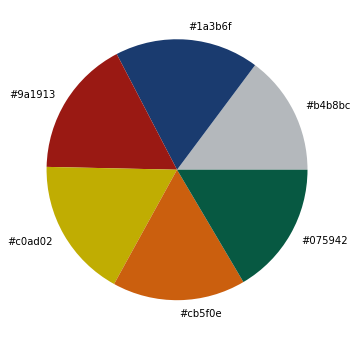

In [8]:
get_colors(get_image('images/colors.jpg'), 6, True)

In [9]:
# [array([184.041793  ,  86.70871917,  27.80222077]), orange
#  array([19.65844721, 99.40294004, 50.53381903]),
#  array([180.95730246, 156.87009815,  11.83821068]),
#  array([23.40360149, 40.62052261, 92.8763946 ]),
#  array([140.70223789,  31.6402395 ,  27.26374793])] red


COLORS = {
    'F': [7,89,67], #green
    'U': [180,185,189], #white
    'D': [180,156,11],#yellow
    'B' : [26,59,120],#blue
    'L':[201,92,19],#orange
    'R':[190,31,33] #red
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [180,156,11],
#     'Blue' : [26,59,120],
#     'Orange':[201,92,19],
#     'Red':[190,31,33]
}

# COLORS = {
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [193,177,2],
#     'Blue' : [26,59,112],
#     'Orange':[180,95,13],
#     'Red':[140,30,37]
# }

In [10]:
# working
def find_colors(img,color_list):
#     img = cv.imread("./images/D1.jpeg")
    original  = img.copy()
#     cv.imshow('img',img)
    height, width, _ = original.shape
    print(f"height = {height}, width = {width}")
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # type of blur which preserves edges
    # blur = cv.bilateralFilter(gray, 7, 7,10)
    # sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # sharpen_kernel_5 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    # sharpen_kernel_4 = np.array([[0,1,0], [1,-4,1], [0,1,0]])

    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen_4 = cv.filter2D(blur, -1, sharpen_kernel_4)
    # sharpen_5 = cv.filter2D(blur, -1, sharpen_kernel_5)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)


    # thresh = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,9,1)
    thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))



    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    # thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)

    cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
    # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    cnts = sorted(cnts, key=lambda x: cv.contourArea(x))


    number = 0
    min_area = 130000
    max_area = 300000
    x = y = w = h = 0
    for c in cnts:
        area = cv.contourArea(c)
        if area > min_area and area < max_area:
            print(area)
            x,y,w,h = cv.boundingRect(c)
    #         print(x,y,w,h,end=" ")
            tmp = original[y:y+h, x:x+w]
    #         cv.imshow("{}".format(number + 1),tmp)
    #         sq_color = identify_color(tmp)
    #         cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
            cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
    #         original[y:y+h,x:x+w] = [255,255,255]
    #         original = cv.circle(original,((x+x+w)//2 , (y+y+h)//2),radius=1, color=(255, 255, 255), thickness=-1)
            number += 1
#             cv.imwrite(f"new_{random.randint(0,100)}.jpeg",tmp)
    #         cv.putText(original, "#{}".formatnumber), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            break

    # cv.imshow('tmp',tmp)
    # print("dims = ",x,y,w,h,end=" ")
    colors = []
    for i in range(1,4):
        for j in range(1,4):
            sq = original[y + (i-1)* (h//3):y+(i)* (h//3),x+(j-1)*(w//3):x+(j)*(w//3)]
    #         cv.rectangle(original,(x+(j-1)*(w//3),y + (i-1)* (h//3)),(x+(j)*(w//3),y+(i)* (h//3)),(36,255,12), 2)
#             original = cv.circle(original, ((x+(j-1)*(w//3) + x+(j)*(w//3))//2 ,(y + (i-1)* (h//3) + y+(i)* (h//3))//2), radius=10, color=(0, 0, 255), thickness=-1)
            color = identify_color(sq,color_list)
            colors.append(color)
            cv.putText(original, "#{}".format(color), (x+(j-1)*(w//3),y + (i-1)* (h//3) - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
    #         cv.imshow(f'square ({i},{j})',sq)\
    colors = ''.join(colors)
    # colors = str(colors)
#     print(colors)
    # cv.imshow('thresh',thresh)
#     resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
#     cv.mshow('resized_thresh',resized_thresh)
    # cv.imshow('sharpen_4',sharpen_4)
    # cv.imshow('sharpen_5',sharpen_5)
    # cv.imshow('blur', blur)
    # cv.imshow('gray',gray)
    # cv.imshow('original', original)
    resized_down = cv.resize(original, (550,1100), interpolation= cv.INTER_LINEAR)
    cv.imshow('resized',resized_down)
    # cv.imshow('sharpen',sharpen)
    cv.waitKey()
    cv.destroyAllWindows()
    return colors

In [11]:
# up,right,front,down,left,back
final_str = "" 
up = cv.imread("./images/U3.jpeg")
up_str = find_colors(up,COLORS)
# find_colors(up)
# print(up_str)
final_str = final_str + up_str

right = cv.imread("./images/R3.jpeg")
right_str = find_colors(right,COLORS)
final_str = final_str + right_str
# print(right_str)

front = cv.imread("./images/F3.jpeg")
front_str = find_colors(front,COLORS)
final_str = final_str + front_str
# print(front_str)

down = cv.imread("./images/D3.jpeg")
down_str = find_colors(down,COLORS)
final_str = final_str + down_str
# print(down_str)

left = cv.imread("./images/L3.jpeg")
left_str = find_colors(left,COLORS)
final_str = final_str + left_str
# print(left_str)

back = cv.imread("./images/B3.jpeg")
back_str = find_colors(back,COLORS)
final_str = final_str + back_str
# print(back_str)
print(final_str)
# # # down = 
# # # UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB
solved = kociemba.solve(final_str)
solved

height = 1600, width = 1201
159641.5
{24: 'B', 43: 'F'}
{24: 'U', 33: 'F', 56: 'B', 58: 'D'}
{36: 'L', 41: 'R', 51: 'D', 54: 'F', 55: 'U'}
{28: 'U', 31: 'F', 55: 'B', 58: 'D'}
{28: 'U', 33: 'F', 54: 'B', 59: 'D'}
{19: 'B', 46: 'F', 58: 'U'}
{15: 'F'}
{44: 'R', 51: 'L', 58: 'B'}
{36: 'L', 40: 'R', 53: 'D', 55: 'U'}
height = 1600, width = 1201
165801.0
{29: 'D', 45: 'F', 48: 'L', 56: 'U'}
{25: 'U', 34: 'F', 57: 'B'}
{7: 'F', 51: 'U'}
{30: 'D', 46: 'L', 58: 'U'}
{39: 'R', 47: 'L'}
{19: 'B', 44: 'F', 55: 'U'}
{12: 'F', 57: 'U'}
{40: 'R', 47: 'L'}
{7: 'F', 49: 'U'}
height = 1600, width = 1201
157840.5
{40: 'R', 45: 'L', 59: 'F'}
{11: 'F', 55: 'U'}
{20: 'B', 41: 'F', 52: 'U'}
{30: 'L', 37: 'R', 49: 'D'}
{12: 'F', 58: 'U'}
{21: 'B', 41: 'F', 50: 'U'}
{24: 'B', 41: 'F', 58: 'U'}
{29: 'L', 36: 'R', 50: 'D'}
{31: 'L', 39: 'R', 48: 'D', 56: 'U', 57: 'F'}
height = 1600, width = 1201
163937.0
{42: 'R', 48: 'L', 59: 'F'}
{26: 'D', 46: 'L', 49: 'F', 59: 'U'}
{24: 'D', 46: 'L', 49: 'F', 56: 'U'}
{45: 

"R F B' U D' R2 F' B' L B U2 L2 F2 U D2 R2 D L2 B2 U'"

In [12]:
# color_list = COLORS
# img = cv.imread("./images/B2.jpeg")
# original  = img.copy()
# cv.imshow('img',img)
# height, width, _ = original.shape
# print(f"height = {height}, width = {width}")
# gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# # type of blur which preserves edges
# # blur = cv.bilateralFilter(gray, 7, 7,10)
# # sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# # sharpen_kernel_5 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
# # sharpen_kernel_4 = np.array([[0,1,0], [1,-4,1], [0,1,0]])

# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
# # sharpen_4 = cv.filter2D(blur, -1, sharpen_kernel_4)
# # sharpen_5 = cv.filter2D(blur, -1, sharpen_kernel_5)
# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)


# # thresh = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,9,1)
# thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
# kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))



# thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
# thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
# # thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)



# cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
# # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# # (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
# cnts = sorted(cnts, key=lambda x: cv.contourArea(x))


# number = 0
# min_area = 100000 
# max_area = 300000
# x = y = w = h = 0
# for c in cnts:
#     area = cv.contourArea(c)
#     if area > min_area and area < max_area:
#         print(area)
#         x,y,w,h = cv.boundingRect(c)
# #         print(x,y,w,h,end=" ")
#         tmp = original[y:y+h, x:x+w]
# #         cv.imshow("{}".format(number + 1),tmp)
# #         sq_color = identify_color(tmp)
#         cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
#         cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
# #         original[y:y+h,x:x+w] = [255,255,255]
# #         original = cv.circle(original,((x+x+w)//2 , (y+y+h)//2),radius=1, color=(255, 255, 255), thickness=-1)
#         number += 1
# #         cv.putText(original, "#{}".formatnumber), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
#         break

# # cv.imshow('tmp',tmp)
# # print("dims = ",x,y,w,h,end=" ")
# colors = []
# for i in range(1,4):
#     for j in range(1,4):
#         sq = original[y + (i-1)* (h//3):y+(i)* (h//3),x+(j-1)*(w//3):x+(j)*(w//3)]
# #         cv.rectangle(original,(x+(j-1)*(w//3),y + (i-1)* (h//3)),(x+(j)*(w//3),y+(i)* (h//3)),(36,255,12), 2)
# #             original = cv.circle(original, ((x+(j-1)*(w//3) + x+(j)*(w//3))//2 ,(y + (i-1)* (h//3) + y+(i)* (h//3))//2), radius=10, color=(0, 0, 255), thickness=-1)
#         color = identify_color(sq,color_list)
#         colors.append(color)
#         cv.putText(original, "#{}".format(color), (x+(j-1)*(w//3),y + (i-1)* (h//3) - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

# #         cv.imshow(f'square ({i},{j})',sq)\
# colors = ''.join(colors)
# # colors = str(colors)
# #     print(colors)
# # cv.imshow('thresh',thresh)
# resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized_thresh',resized_thresh)
# # cv.imshow('sharpen_4',sharpen_4)
# # cv.imshow('sharpen_5',sharpen_5)
# # cv.imshow('blur', blur)
# # cv.imshow('gray',gray)
# # cv.imshow('original', original)
# resized_down = cv.resize(original, (550,1100), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized',resized_down)
# # cv.imshow('sharpen',sharpen)
# cv.waitKey()
# cv.destroyAllWindows()
# # return colors

In [13]:
# latest
# def find_colors(img):
#     original  = img.copy()
#     gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
#     thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
#     kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
#     thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
#     thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
#     cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#     cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
#     number = x=y=h=w=0
#     min_area = 130000
#     max_area = 300000
#     for c in cnts:
#         area = cv.contourArea(c)
#         if area > min_area and area < max_area:
#             print(area)
#             x,y,w,h = cv.boundingRect(c)
# #             print(x,y,w,h,end=" ")
#             tmp = original[y:y+h, x:x+w]
# #             cv.imshow("{}".format(number + 1),tmp)
# #             sq_color = get_color(tmp)
#     #         cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
#             cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
# #             original = cv.circle(original,((x+x+w)//2 , (y+y+h)//2),radius=0, color=(0, 0, 255), thickness=-1)
#             number += 1
# #             cv.imshow('tmp',tmp)
# #             cv.putText(original, "#{}".format(number), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
#             break

    
#     # print("dims = ",x,y,w,h,end=" ")
#     colors = ""
#     for i in range(1,4):
#         for j in range(1,4):
#             sq = original[y + (i-1)* (h//3):y+(i)* (h//3),x+(j-1)*(w//3):x+(j)*(w//3)]
#             cv.rectangle(original,(x+(j-1)*(w//3),y + (i-1)* (h//3)),(x+(j)*(w//3),y+(i)* (h//3)),(36,255,12), 2)
#     #         original = cv.circle(original, ((x+(j-1)*(w//3) + x+(j)*(w//3))//2 ,(y + (i-1)* (h//3) + y+(i)* (h//3))//2), radius=10, color=(0, 0, 255), thickness=-1)
#             color = get_color(sq)
#             colors = colors + color
# #             colors.append(color)
#             cv.putText(original, "#{} ({},{})".format(color,i,j), (x+(j-1)*(w//3),y + (i-1)* (h//3) - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
# #     colors = ''.join(colors)
#     # colors = str(colors)
# #     print(colors)
#     # cv.imshow('thresh',thresh)
#     # resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
#     # cv.imshow('resized_thresh',resized_thresh)

#     # cv.imshow('sharpen_4',sharpen_4)
#     # cv.imshow('sharpen_5',sharpen_5)
#     # cv.imshow('blur', blur)
#     # cv.imshow('gray',gray)
#     # cv.imshow('original', original)
#     resized_down = cv.resize(original, (300,600), interpolation= cv.INTER_LINEAR)
#     cv.imshow('resized',resized_down)
#     # cv.imshow('sharpen',sharpen)
#     cv.waitKey()
#     cv.destroyAllWindows()
#     print("string is ",colors)
#     return colors

In [14]:
# img = cv.imread("./images/D1.jpeg")
# original  = img.copy()
# # cv.imshow('img',img)
# height, width, _ = original.shape
# print(f"height = {height}, width = {width}")
# gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# # type of blur which preserves edges
# # blur = cv.bilateralFilter(gray, 7, 7,10)
# # sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# # sharpen_kernel_5 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
# # sharpen_kernel_4 = np.array([[0,1,0], [1,-4,1], [0,1,0]])

# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
# # sharpen_4 = cv.filter2D(blur, -1, sharpen_kernel_4)
# # sharpen_5 = cv.filter2D(blur, -1, sharpen_kernel_5)
# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)


# # thresh = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,9,1)
# thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
# kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))



# thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
# thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
# # thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)

# cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
# # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# # (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
# cnts = sorted(cnts, key=lambda x: cv.contourArea(x))


# number = 0
# min_area = 130000
# max_area = 300000
# x = y = w = h = 0
# for c in cnts:
#     area = cv.contourArea(c)
    
#     if area > min_area and area < max_area:
#         print(area)
#         x,y,w,h = cv.boundingRect(c)
# #         print(x,y,w,h,end=" ")
#         tmp = original[y:y+h, x:x+w]
# #         cv.imshow("{}".format(number + 1),tmp)
# #         sq_color = get_color(tmp)
# #         cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
#         cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
# #         original[y:y+h,x:x+w] = [255,255,255]
# #         original = cv.circle(original,((x+x+w)//2 , (y+y+h)//2),radius=1, color=(255, 255, 255), thickness=-1)
#         number += 1
# #         cv.putText(original, "#{}".formatnumber), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
#         break

# # cv.imshow('tmp',tmp)
# # print("dims = ",x,y,w,h,end=" ")
# colors = []
# for i in range(1,4):
#     for j in range(1,4):
#         sq = original[y + (i-1)* (h//3):y+(i)* (h//3),x+(j-1)*(w//3):x+(j)*(w//3)]
# #         cv.rectangle(original,(x+(j-1)*(w//3),y + (i-1)* (h//3)),(x+(j)*(w//3),y+(i)* (h//3)),(36,255,12), 2)
# #         original = cv.circle(original, ((x+(j-1)*(w//3) + x+(j)*(w//3))//2 ,(y + (i-1)* (h//3) + y+(i)* (h//3))//2), radius=10, color=(0, 0, 255), thickness=-1)
#         color = get_color(sq)
#         colors.append(color)
#         cv.putText(original, "#{} ({},{})".format(color,i,j), (x+(j-1)*(w//3),y + (i-1)* (h//3) - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
# #         cv.imshow(f'square ({i},{j})',sq)\
# colors = ''.join(colors)
# # colors = str(colors)
# print(colors)
# # cv.imshow('thresh',thresh)
# # resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
# # cv.mshow('resized_thresh',resized_th5
# # cv.imshow('sharpen_4',sharpen_4)
# # cv.imshow('sharpen_5',sharpen_5)
# # cv.imshow('blur', blur)
# # cv.imshow('gray',gray)
# # cv.imshow('original', original)
# resized_down = cv.resize(original, (1000,1000), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized',resized_down)
# # cv.imshow('sharpen',sharpen)
# cv.waitKey()
# cv.destroyAllWindows()

In [15]:
# img = cv.imread("./images/D1.jpeg")
# original  = img.copy()
# cv.imshow('img',img)
# cv.waitKey()
# cv.destroyAllWindows()

In [16]:
# def identify_color(frame):
#     hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
#     height, width, _ = frame.shape
#     cx = int(width / 2)
#     cy = int(height / 2)
    
#     # Pick pixel value
#     pixel_center = hsv_frame[cy, cx]
#     hue_value = pixel_center[0]
#     print(f"hue val is {hue_value}")
# # DRLUUBFBRBLURRLRUBLRDDFDLFUFUFFDBRDUBRUFLLFDDBFLUBLRBD
#     color = "Undefined"
#     if hue_value < 10:
# #         color = 'L' #for orange
#         print("Selected orange")
#         print()
#         color = "orange "
#     elif hue_value < 35:
# #         color = 'D' #for yellow
#         print("Selected yellow")
#         print()

#         color = "yellow "
#     elif hue_value < 90:
# #         color = 'F' #for green
#         print("Selected green")
#         print()
    
#         color = "green "
#     elif hue_value < 108:
# #         color = 'U' #for white
#         print("Selected white")
#         print()

#         color = "white "
#     elif hue_value < 150:
# #         color = 'B' #for blue
#         print("Selected blue")
#         print()

#         color = "blue "
#     elif hue_value < 200:
# #         color = 'R' #for red
#         print("Selected red")
#         print()

#         color = "red "
#     return color

In [17]:
# cap = cv.VideoCapture(0)
# index = 1
# while True:
#     cubeImg = np.zeros((480,640))
#     res, cubeImg = cap.read()
#     cv.waitKey(10)
# #     drawCube(cubeImg,180,3,(100,60))
#     cv.imshow("cube",cubeImg)
#     break;

In [18]:
# img = cv.imread("images/20.jpeg")
# original  = img.copy()
# # cv.imshow('img',img)
# gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# # type of blur which preserves edges
# blur = cv.bilateralFilter(gray, 7, 7,10)
# sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# # sharpen_kernel_5 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
# # sharpen_kernel_4 = np.array([[0,1,0], [1,-4,1], [0,1,0]])

# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
# # sharpen_4 = cv.filter2D(blur, -1, sharpen_kernel_4)
# # sharpen_5 = cv.filter2D(blur, -1, sharpen_kernel_5)
# # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
# sharpen = cv.filter2D(blur, -1, sharpen_kernel)


# thresh = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,9,1)
# # thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
# kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))



# thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
# thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
# # thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)

# cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
# # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

# cnts = cnts[0] if len(cnts) == 2 else cnts[1]


# number = 0
# min_area = 100
# max_area = 10000
# for c in cnts:
#     area = cv.contourArea(c)
    
#     if area > min_area and area < max_area:
#         print(area)
#         x,y,w,h = cv.boundingRect(c)
#         print(x,y,w,h,end=" ")
#         tmp = original[y:y+h, x:x+w]
# #         cv.imshow("{}".format(number + 1),tmp)
# #         sq_color = get_color(tmp)
#         cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
# #         cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
# #         cv.putText(original, "#{}".format(sq_color), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
#         number += 1

# # cv.imshow('thresh',thresh)
# resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized_thresh',resized_thresh)

# # cv.imshow('sharpen_4',sharpen_4)
# # cv.imshow('sharpen_5',sharpen_5)
# # cv.imshow('blur', blur)
# # cv.imshow('gray',gray)
# # cv.imshow('original', original)
# resized_down = cv.resize(original, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized',resized_down)
# # cv.imshow('sharpen',sharpen)
# cv.waitKey()
# cv.destroyAllWindows()

In [19]:
# import cv2
# import numpy as np

# # Load image, grayscale, median blur, sharpen image
# image = cv.imread('images/20.jpeg')
# gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# blur = cv.medianBlur(gray, 5)
# sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# sharpen = cv.filter2D(blur, -1, sharpen_kernel)

# # Threshold and morph close
# thresh = cv.threshold(sharpen, 160, 255, cv.THRESH_BINARY_INV)[1]
# kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
# close = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=2)

# # Find contours and filter using threshold area
# cnts = cv.findContours(close, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# min_area = 0
# max_area = 100000
# image_number = 0
# for c in cnts:
#     area = cv.contourArea(c)
#     if area > min_area and area < max_area:
#         x,y,w,h = cv.boundingRect(c)
#         ROI = image[y:y+h, x:x+w]
# #         cv.imwrite('ROI_{}.png'.format(image_number), ROI)
#         cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
#         cv.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
#         image_number += 1
# resized_down = cv.resize(image, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized',resized_down)

# cv.imshow('sharpen', sharpen)
# cv.imshow('close', close)
# cv.imshow('thresh', thresh)
# cv.imshow('image', image)
# cv.waitKey()
# cv.destroyAllWindows()

In [20]:
# img = cv.imread("images/20.jpeg")
# original = img.copy()

# # img = cv.GaussianBlur(img, (3,3), 0)
# gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# # canny = cv.Canny(img,124,124)
# # cv.imshow('canny',canny)

# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
# gray = cv.morphologyEx(gray, cv.MORPH_OPEN, kernel)
# gray = cv.morphologyEx(gray, cv.MORPH_CLOSE, kernel)

# thresh = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
# # thresh = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,9,2)

# # Threshold and morph close
# # thresh = cv.threshold(gray, 125, 255, cv.THRESH_BINARY_INV)[1]
# # kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
# close = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=2)

# # Find contours and filter using threshold area
# cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
# # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

# cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# number = 0
# min_area = 1000
# max_area = 10000
# for c in cnts:
#     area = cv.contourArea(c)
    
#     if area > min_area and area < max_area:
#         print(area)
#         x,y,w,h = cv.boundingRect(c)
#         print(x,y,w,h,end=" ")
#         tmp = original[y:y+h, x:x+w]
# #         cv.imshow("{}".format(number + 1),tmp)
# #         sq_color = get_color(tmp)
#         cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
# #         cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
# #         cv.putText(original, "#{}".format(sq_color), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
#         number += 1

# # cv.imshow('sharpen', sharpen)
# cv.imshow('close', close)
# cv.imshow('thresh', thresh)
# cv.imshow('img', img) 
# cv.imshow('gray',gray)
# cv.imshow('original', original)
# resized_down = cv.resize(original, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized',resized_down)
# cv.waitKey()
# cv.destroyAllWindows()

In [21]:
# bgr_image_input = cv.imread("images/20.jpeg")

# original = bgr_image_input.copy()
# # height, width = bgr_image_input.shape[:2]
# # bgr_image_input = cv.GaussianBlur(bgr_image_input, (3,3), 0)
# gray = cv.cvtColor(bgr_image_input,cv.COLOR_BGR2GRAY)

# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
# gray = cv.morphologyEx(gray, cv.MORPH_OPEN, kernel)
# gray = cv.morphologyEx(gray, cv.MORPH_CLOSE, kernel)

# # gray = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,5,0)
# (thresh, im_bw) = cv.threshold(gray, 150, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
# thresh = 127
# im_bw = cv.threshold(gray, 42, 255, cv.THRESH_BINARY)[1]
# cv.imshow("Black and white",im_bw)

# cnts = cv.findContours(im_bw, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# # Sort all contours from top-to-bottom or bottom-to-top
# (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

# # for contour in contours:
# #         A1 = cv.contourArea(contour)
# #         contour_id = contour_id + 1
# #         print(A1)
# # Take each row of 3 and sort from left-to-right or right-to-left

# cube_rows = []
# row = []

# for (i, c) in enumerate(cnts, 1):
#     row.append(c)
#     if i % 3 == 0:  
#         (cnts, _) = contours.sort_contours(row, method="left-to-right")
#         cube_rows.append(cnts)
#         row = []

# # Draw text
# number = 0
# for row in cube_rows:
#     for c in row:
#         x,y,w,h = cv.boundingRect(c)
#         tmp = original[y:y+h, x:x+w]
# #         cv.imshow("{}".format(number + 1),tmp)
# #         sq_color = get_color(tmp)
#         cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
# #         cv.putText(original, "#{}".format(sq_color), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
#         number += 1

# cv.imshow('gray', gray)
# cv.imshow('original', original)
# resized_down = cv.resize(original, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized',resized_down)
# cv.waitKey()
# cv.destroyAllWindows()

In [22]:
# # Working
# img = cv.imread("images/23.jpeg")

# original = img.copy()
# img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
# mask = np.zeros(img.shape, dtype=np.uint8)

# colors = {
# #     'white':([0,0,168],[172,111,255]),
# #     'red':([0,0,0],[179,255,255]),
#     'green': ([76, 0, 41], [179, 255, 70]),        
#     'blue': ([69, 120, 100], [179, 255, 255]),    # Blue
#     'yellow': ([21, 110, 117], [45, 255, 255]),   # Yellow
#     'orange': ([0, 110, 125], [17, 255, 255])     # Orange
#     }

# # Color threshold to find the squares
# open_kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
# close_kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
# for color, (lower, upper) in colors.items():
#     lower = np.array(lower, dtype=np.uint8)
#     upper = np.array(upper, dtype=np.uint8)
#     color_mask = cv.inRange(img, lower, upper)
#     color_mask = cv.morphologyEx(color_mask, cv.MORPH_OPEN, open_kernel, iterations=1)
#     color_mask = cv.morphologyEx(color_mask, cv.MORPH_CLOSE, close_kernel, iterations=5)

#     color_mask = cv.merge([color_mask, color_mask, color_mask])
#     mask = cv.bitwise_or(mask, color_mask)
# gray = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

# cnts = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# # Sort all contours from top-to-bottom or bottom-to-top
# (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

# # Take each row of 3 and sort from left-to-right or right-to-left
# cube_rows = []
# row = []
# for (i, c) in enumerate(cnts, 1):
#     row.append(c)
#     if i % 3 == 0:  
#         (cnts, _) = contours.sort_contours(row, method="left-to-right")
#         cube_rows.append(cnts)
#         row = []

# # Draw text
# number = 0
# for row in cube_rows:
#     for c in row:
#         x,y,w,h = cv.boundingRect(c)

#         tmp = original[y:y+h, x:x+w]
#         area = h*w
#         print(area)
#         if(area>10000 and area<100000):
#     #         cv.imshow("{}".format(number + 1),tmp)
# #             sq_color = get_color(tmp)
#             cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
# #             cv.putText(original, "#{}".format(sq_color), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
#             number += 1

# # cv.imshow('mask', mask)
# # cv.imshow('gray', gray)
# resized_thresh = cv.resize(mask, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized_thresh',resized_thresh)
# # cv.imwrite('mask.png', mask)
# resized_down = cv.resize(original, (300,600), interpolation= cv.INTER_LINEAR)
# cv.imshow('resized',resized_down)
# # cv.imshow('original', original)
# cv.waitKey()
# cv.destroyAllWindows()

In [23]:
# img = cv.imread("images/1.jpg")
# print(detect_face(img))
# cv.imshow("Original image",gray)
# cv.waitKey()
# cv.destroyAllWindows()

In [24]:
# import cv2
# import sys
# import numpy as np

# def nothing(x):
#     pass

# # Load in image
# image = cv.imread('images/green.jpeg')

# # Create a window
# cv.namedWindow('image')

# # create trackbars for color change
# cv.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
# cv.createTrackbar('SMin','image',0,255,nothing)
# cv.createTrackbar('VMin','image',0,255,nothing)
# cv.createTrackbar('HMax','image',0,179,nothing)
# cv.createTrackbar('SMax','image',0,255,nothing)
# cv.createTrackbar('VMax','image',0,255,nothing)

# # Set default value for MAX HSV trackbars.
# cv.setTrackbarPos('HMax', 'image', 179)
# cv.setTrackbarPos('SMax', 'image', 255)
# cv.setTrackbarPos('VMax', 'image', 255)

# # Initialize to check if HSV min/max value changes
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# output = image
# wait_time = 33

# while(1):

#     # get current positions of all trackbars
#     hMin = cv.getTrackbarPos('HMin','image')
#     sMin = cv.getTrackbarPos('SMin','image')
#     vMin = cv.getTrackbarPos('VMin','image')

#     hMax = cv.getTrackbarPos('HMax','image')
#     sMax = cv.getTrackbarPos('SMax','image')
#     vMax = cv.getTrackbarPos('VMax','image')

#     # Set minimum and max HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])

#     # Create HSV Image and threshold into a range.
#     hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
#     mask = cv.inRange(hsv, lower, upper)
#     output = cv.bitwise_and(image,image, mask= mask)

#     # Print if there is a change in HSV value
#     if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
#         print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
#         phMin = hMin
#         psMin = sMin
#         pvMin = vMin
#         phMax = hMax
#         psMax = sMax
#         pvMax = vMax

#     # Display output image
#     cv.imshow('image',output)

#     # Wait longer to prevent freeze for videos.
# #     if cv.waitKey(wait_time) & 0xFF == ord('q'):
# #         break
# cv.waitKey()

# cv.destroyAllWindows()